In [2]:

import matplotlib.pyplot as plt
import numpy as np
import torch
from muutils.dbg import dbg_auto

from spd.clustering.activations import component_activations, process_activations
from spd.clustering.merge import compute_merge_costs, merge_iteration
from spd.clustering.merge_matrix import GroupMerge
from spd.experiments.resid_mlp.resid_mlp_dataset import ResidualMLPDataset
from spd.models.component_model import ComponentModel
from spd.utils.data_utils import DatasetGeneratedDataLoader

DEVICE: str = "cuda" if torch.cuda.is_available() else "cpu"

# magic autoreload
%load_ext autoreload
%autoreload 2


In [4]:
component_model, cfg, path = ComponentModel.from_pretrained("wandb:goodfire/spd/runs/dcjm9g2n")
component_model.to(DEVICE);

Downloaded checkpoint from /home/miv/projects/MATS/spd/wandb/5mk5h1lk/files/resid_mlp.pth


In [5]:
N_SAMPLES: int = 512

dataset = ResidualMLPDataset(
    n_features=component_model.model.config.n_features,
    feature_probability=cfg.task_config.feature_probability,
    device=DEVICE,
    calc_labels=False,  # Our labels will be the output of the target model
    label_type=None,
    act_fn_name=None,
    label_fn_seed=None,
    label_coeffs=None,
    data_generation_type=cfg.task_config.data_generation_type,
    # synced_inputs=synced_inputs,
)

dbg_auto(dict(
    n_features=dataset.n_features,
    feature_probability=dataset.feature_probability,
    data_generation_type=dataset.data_generation_type,
))

dataloader = DatasetGeneratedDataLoader(dataset, batch_size=N_SAMPLES, shuffle=False)


[ <ipykernel>:16 ] dict(
: <dict of len()=3, key_types={str}, val_types={float, int, str}>
  n_features: 100
  feature_probability: 0.01
  data_generation_type: 'at_least_zero_active'


In [6]:
ci = component_activations(
	component_model,
	dataloader,
	device=DEVICE,
	# threshold=0.1,
)

dbg_auto(ci);

[ <ipykernel>:8 ] ci: <dict of len()=2, key_types={str}, val_types={Tensor}>
  layers.0.mlp_in: μ=0.01 σ=0.09 x̃=0.00 R=[0.00,1.00] ℙ˪=|█▂▂▂▂▃▄| shape=(512,100) dtype=torch.float32 device=cuda:0 ∇✗
  layers.0.mlp_out: μ=0.06 σ=0.18 x̃=0.00 R=[0.00,1.00] ℙ˪=|█▅▅▅▅▅▅| shape=(512,100) dtype=torch.float32 device=cuda:0 ∇✗


[ activations.py:302 ] total_c = 200
[ activations.py:323 ] (len(dead_components_lst), len(labels)) = (50, 150)
[ activations.py:339 ] output: <dict of len()=7, key_types={str}, val_types={Tensor, int, list}>
  activations: μ=0.04 σ=0.17 x̃=0.00 R=[0.00,1.00] ℙ˪=|█▅▅▅▅▅▅| shape=(512,150) dtype=torch.float32 device=cuda:0 ∇✗
  labels: <list of len()=150, types={str}>
  coactivations: μ=2.21 σ=5.04 x̃=0.14 R=[0.00,48.03] ℙ˪=|█▅▆▄▂▂▂| shape=(150,150) dtype=torch.float32 device=cuda:0 ∇✗
  dead_components_lst: <list of len()=50, types={str}>
  n_components_original: 200
  n_components_alive: 150
  n_components_dead: 50


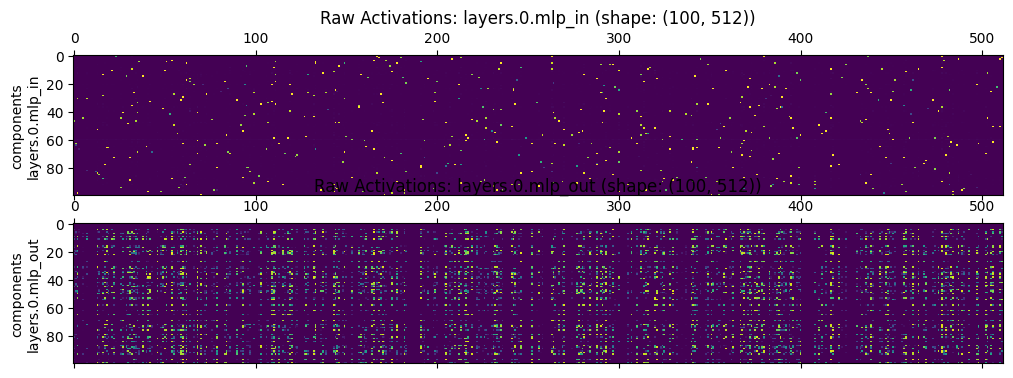

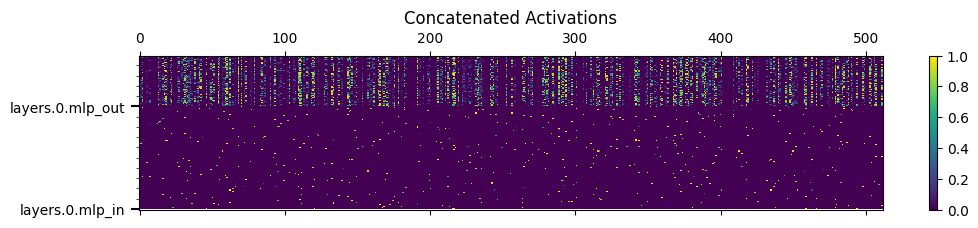

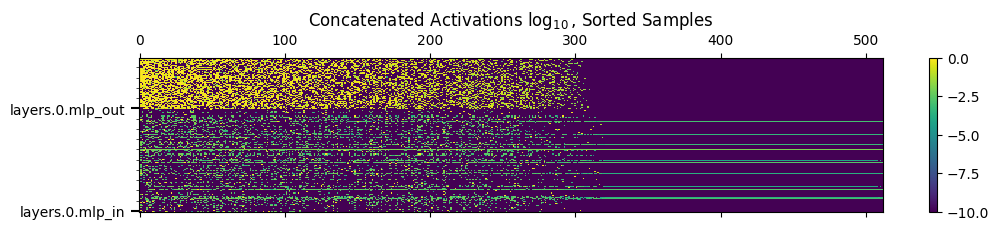

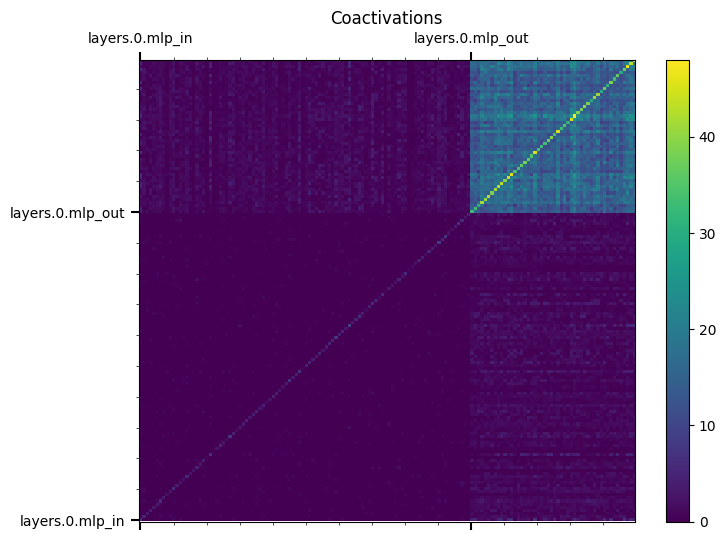

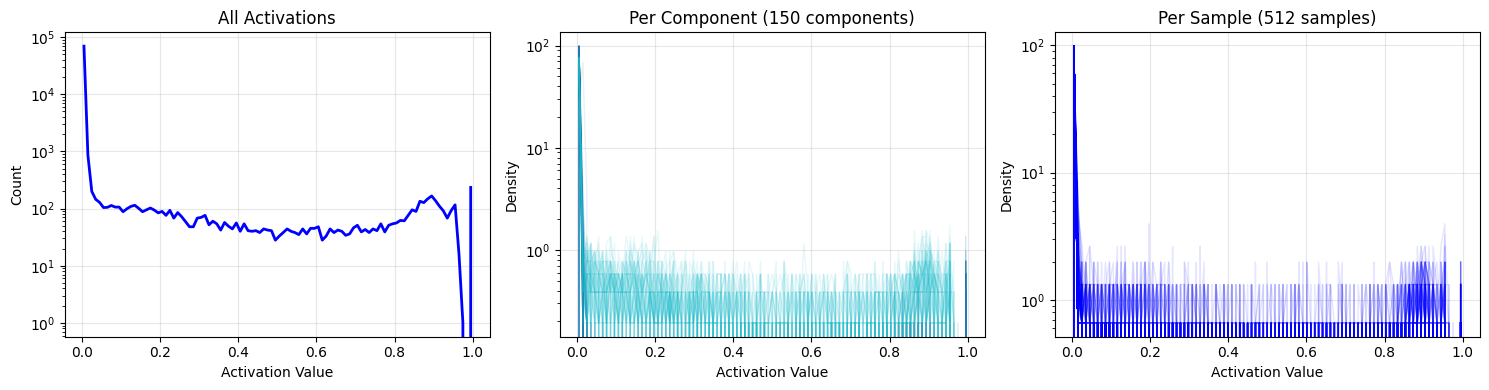

In [7]:
coa = process_activations(
	ci,
	filter_dead_threshold=0.001,
	plots=True,
);

$$
	F_g := \frac{\alpha}{n}
	\Bigg[
		d(A(g)) \cdot Q^T 
		+ Q \cdot d(A(g))^T
		- \Big(
			R \mathbf{1}^T
			+ \mathbf{1} R^T + \alpha^{-1}
		\Big) 
		\odot A(g)
	\Bigg]
$$

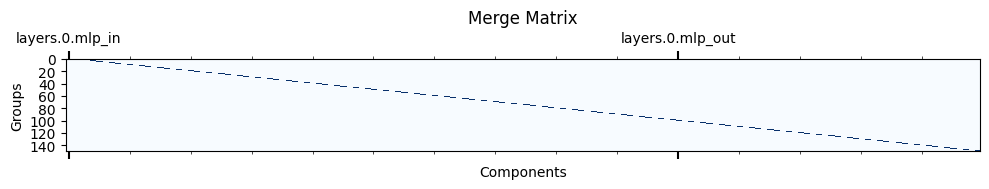

/home/miv/projects/MATS/spd/spd/clustering/merge.py:118: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4413.)
  diag @ ranks.T


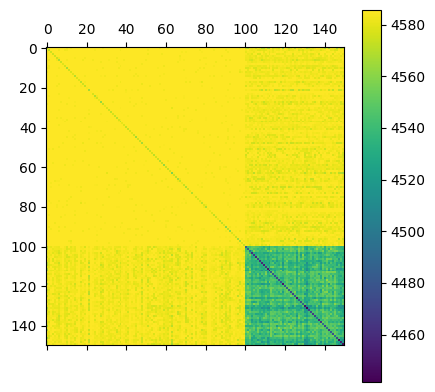

In [8]:
gm_ident = GroupMerge.identity(n_components=coa["n_components_alive"])
gm_ident.plot(figsize=(10, 2), component_labels=coa["labels"])
costs = compute_merge_costs(
	coact=coa['coactivations'],
	merges=gm_ident,
)
plt.matshow(costs.cpu(), cmap='viridis')
plt.colorbar();

/home/miv/projects/MATS/spd/.venv/lib/python3.13/site-packages/muutils/tensor_info.py:264: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, bins = np.histogram(A_hist, bins=hist_bins)
[ <ipykernel>:3 ] act_bool: μ=0.04 σ=0.20 x̃=0.00 R=[0,1] ℙ˪=|█     ▆| shape=(512,150) dtype=torch.bool device=cuda:0 ∇✗


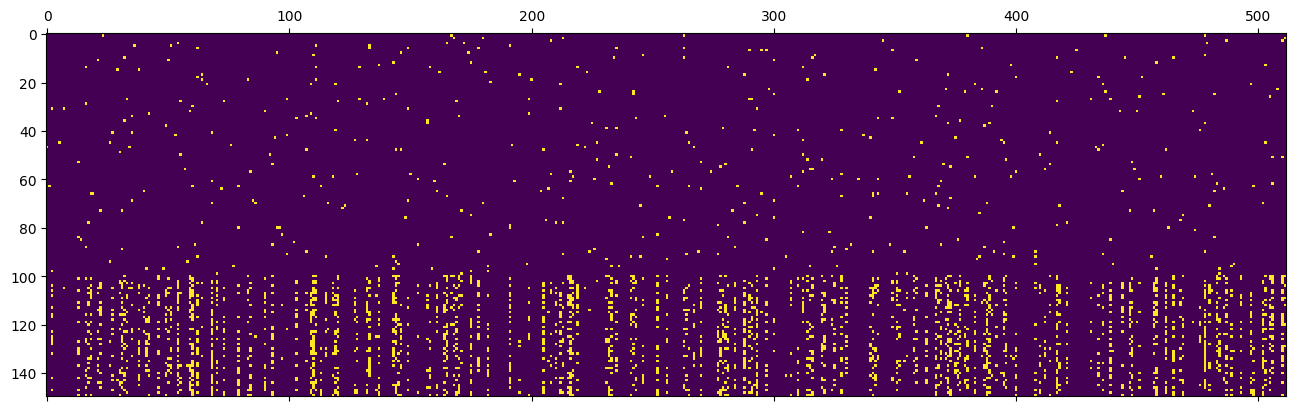

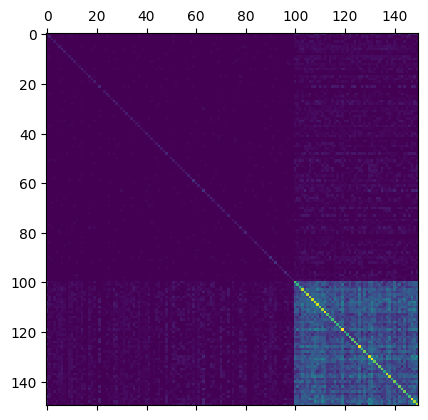

In [9]:

act_bool = coa['activations'] > 0.5
plt.matshow(act_bool.cpu().T, cmap='viridis')
dbg_auto(act_bool)
plt.matshow((act_bool.float().T @ act_bool.float()).cpu(), cmap='viridis')


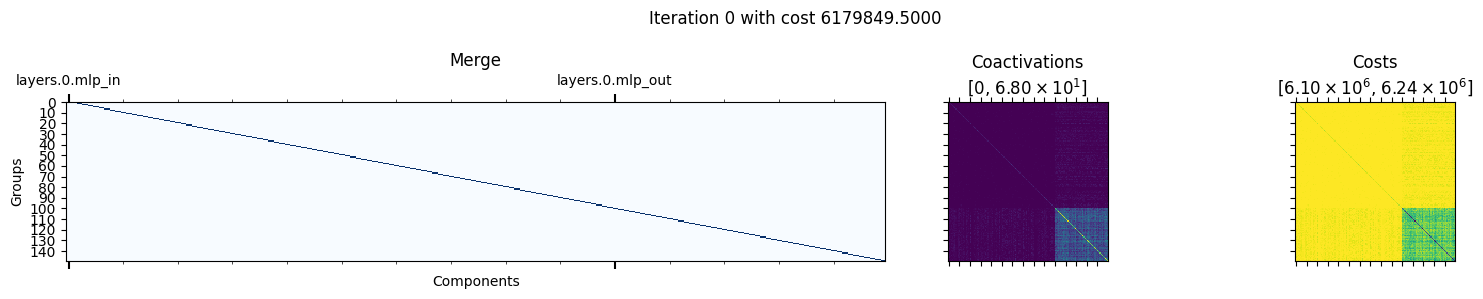

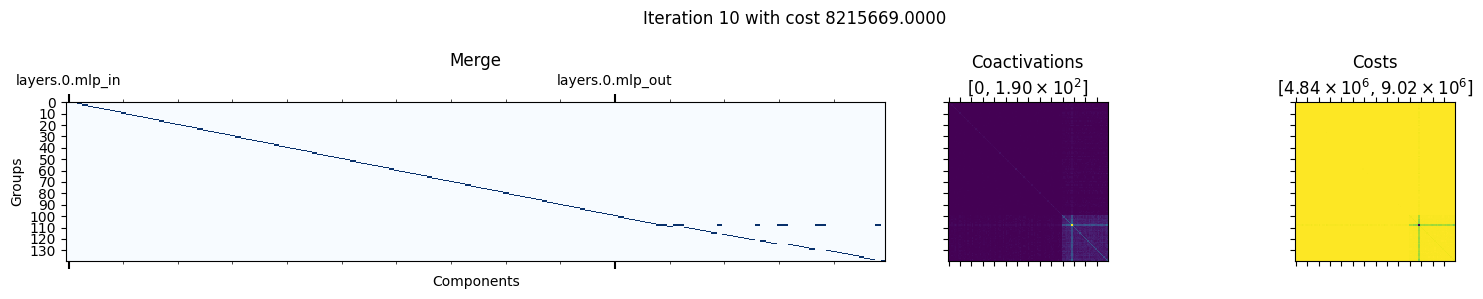

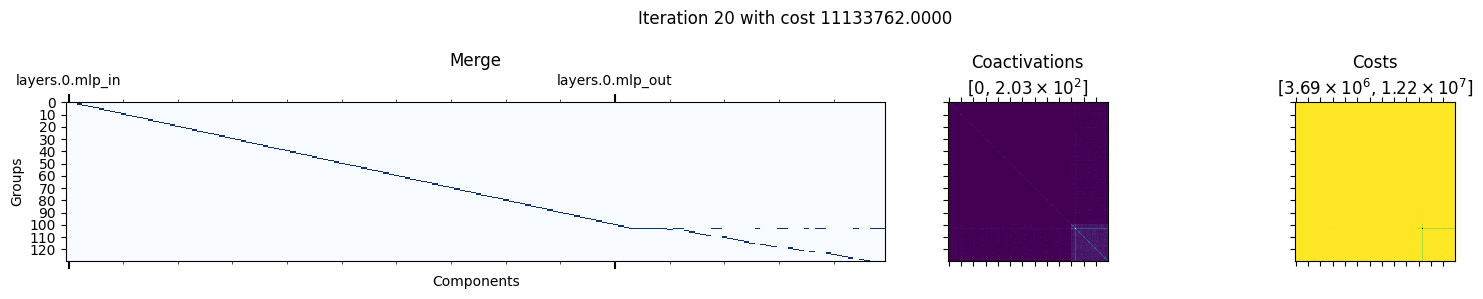

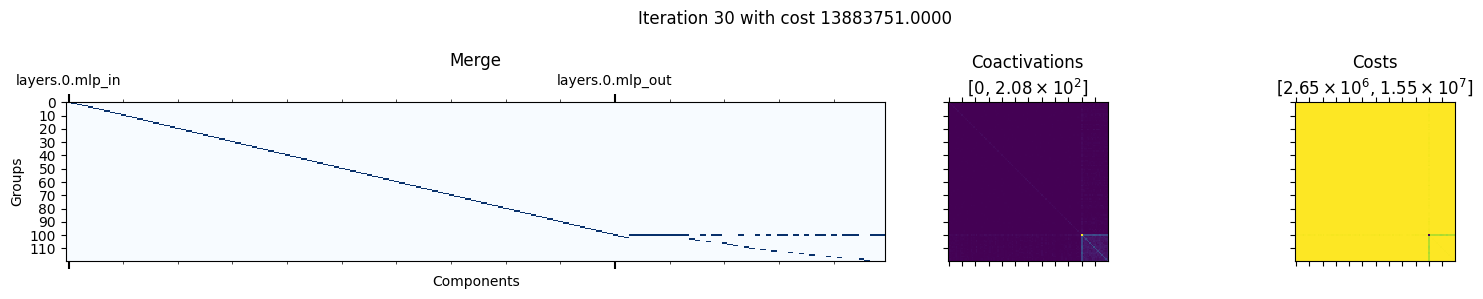

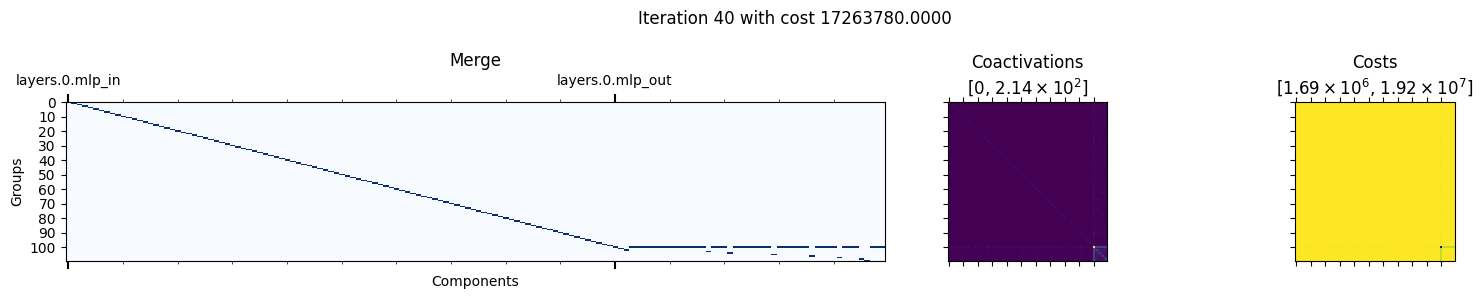

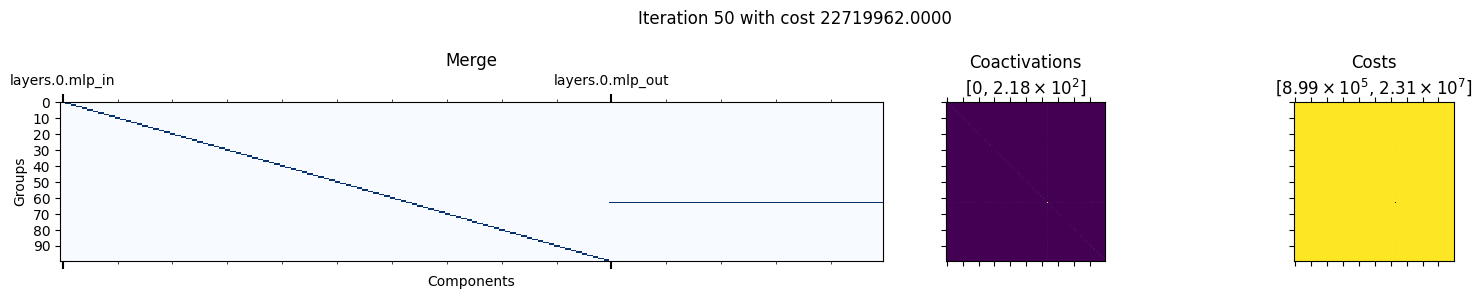

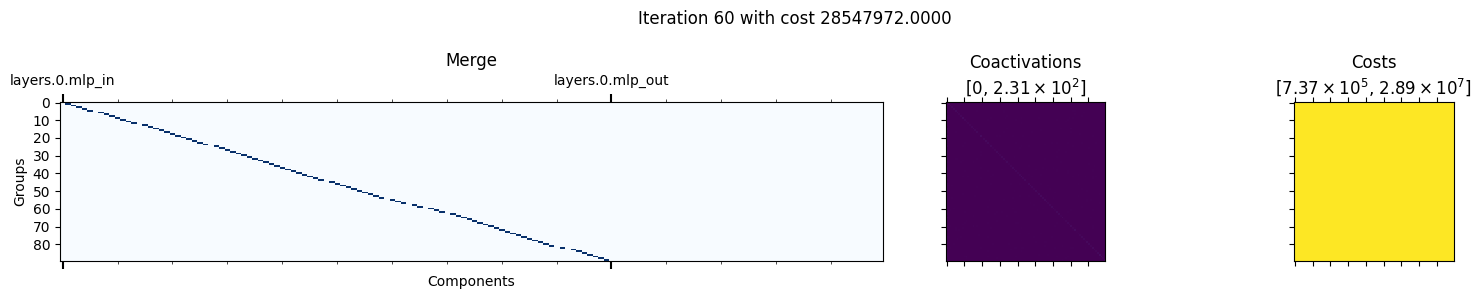

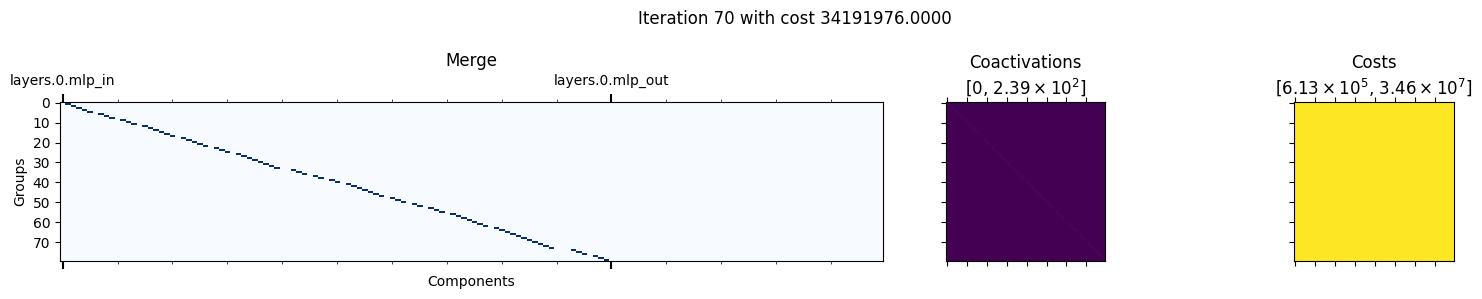

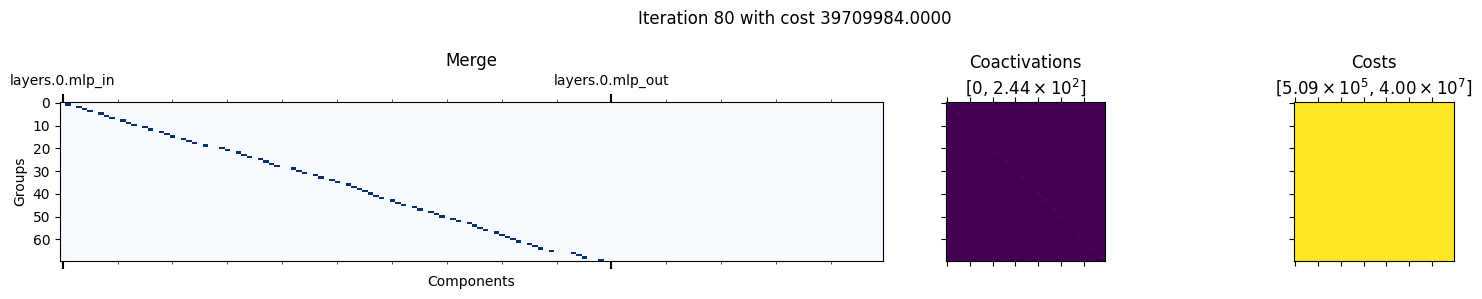

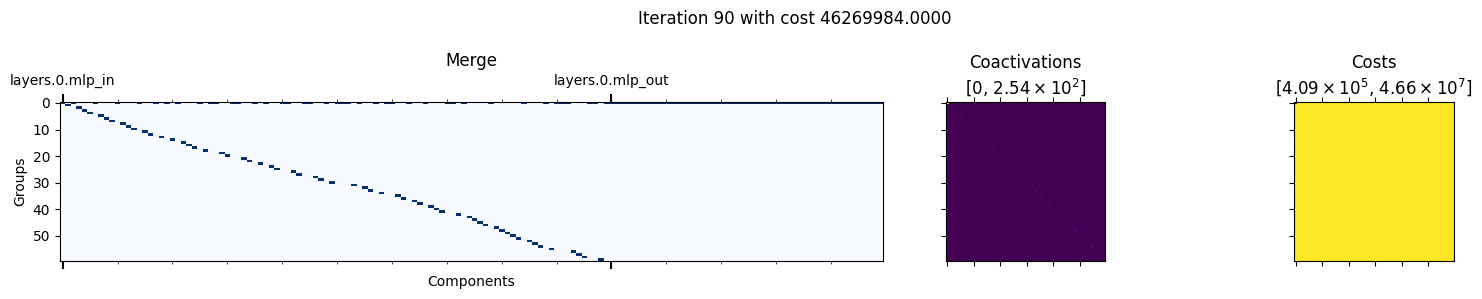

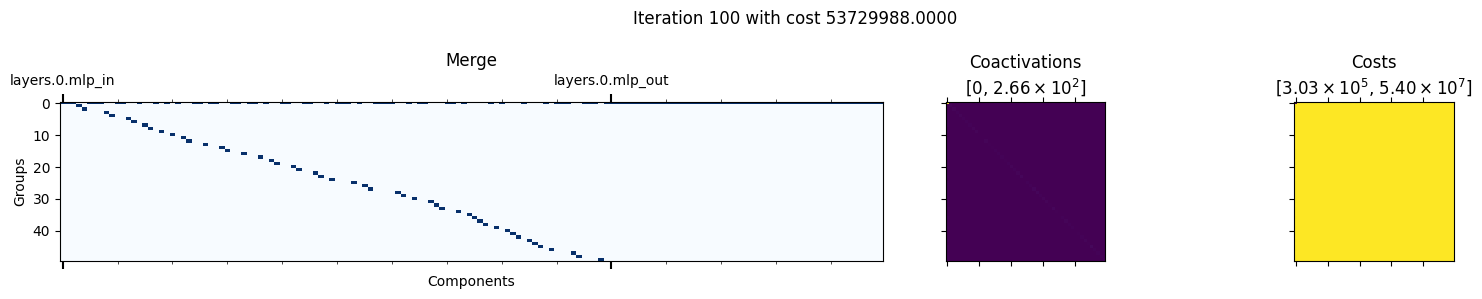

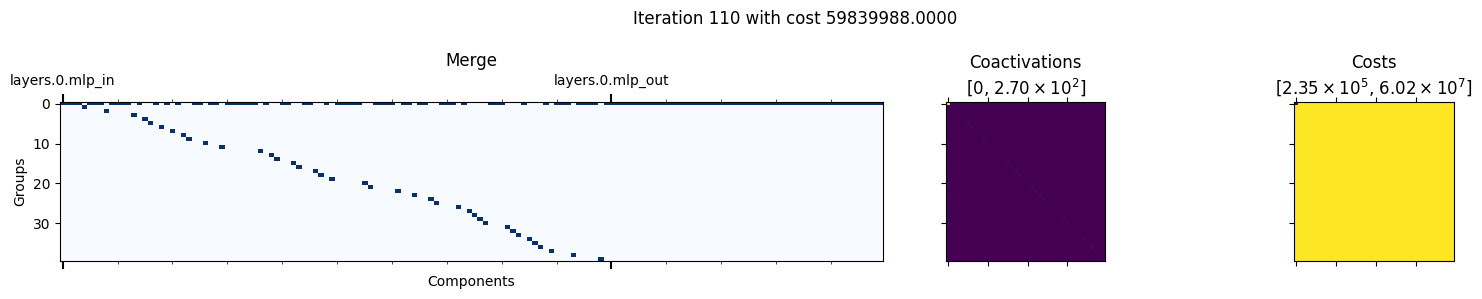

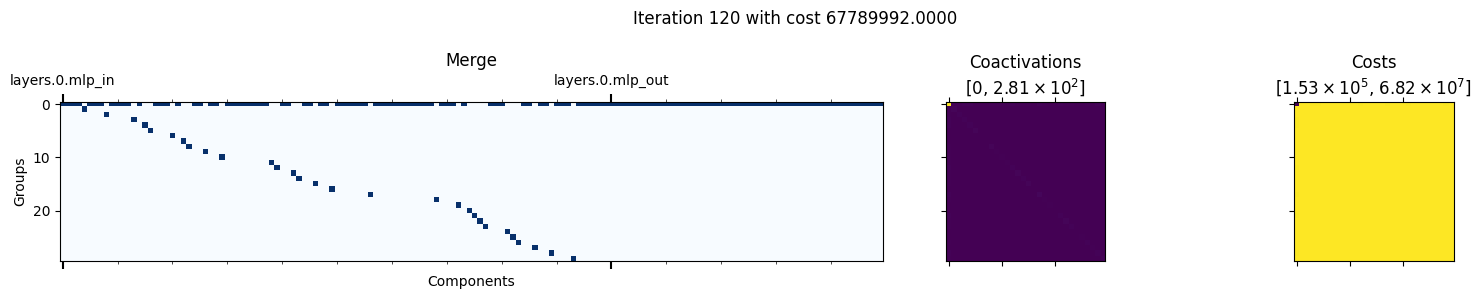

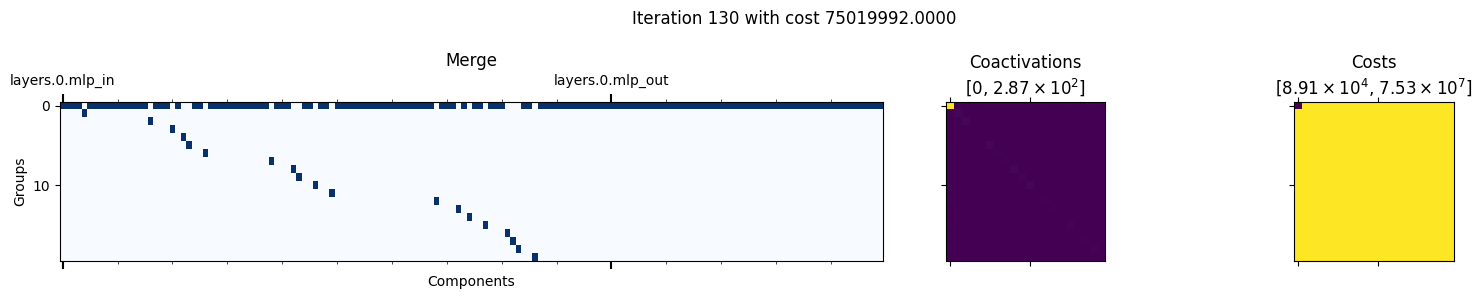

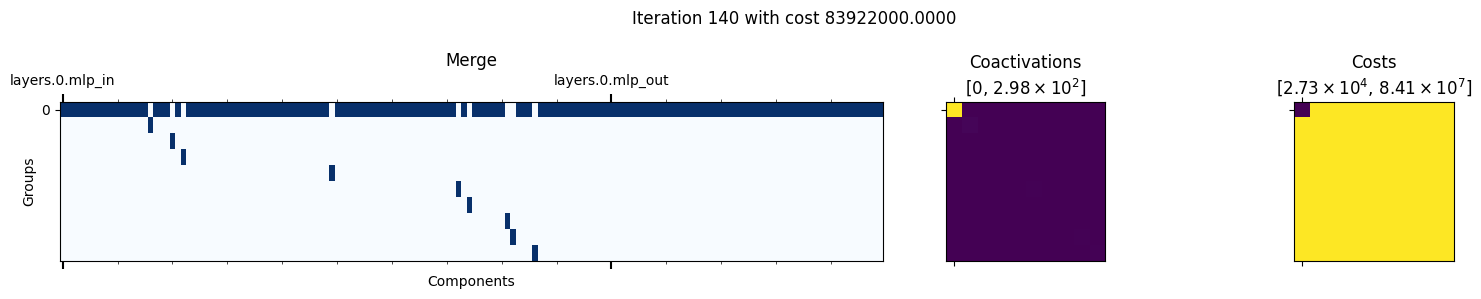

<string>:48: UserWarning: Stopping early at iteration 147 as only 2 groups left


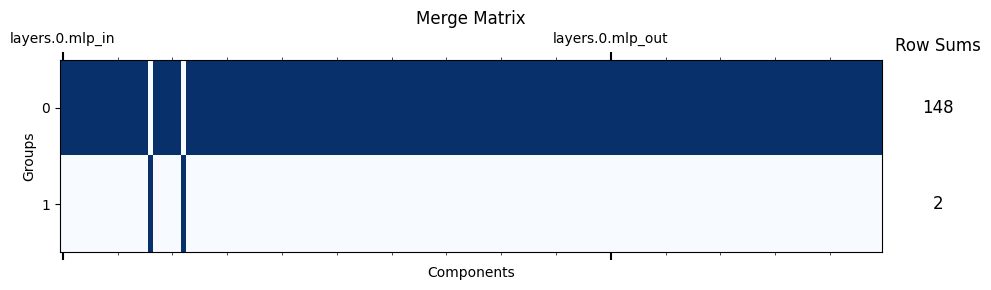

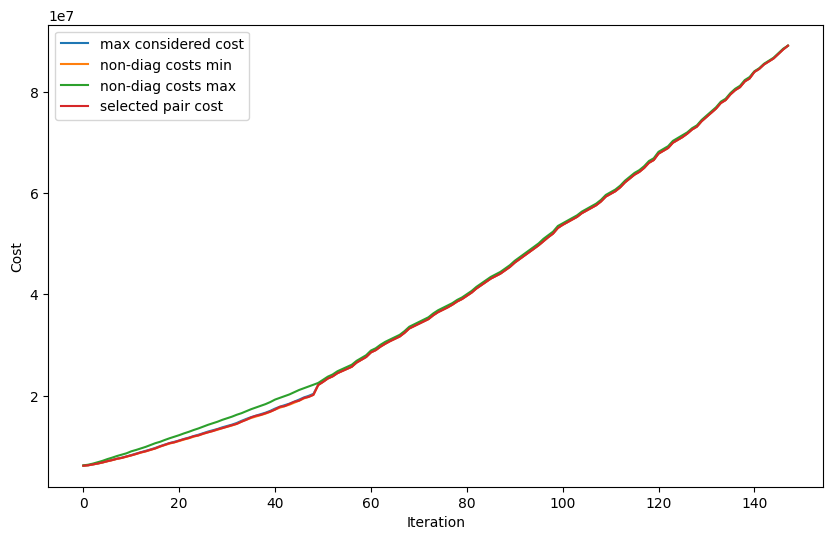

In [14]:


merge_iteration(
	coact=act_bool.float().T @ act_bool.float(),
	activation_mask=act_bool,
	check_threshold=0.1,
	# initial_merge=?,
	# rank_cost=lambda _: 100,
	# rank_cost_fn=lambda _: 0.001,
	rank_cost_fn=lambda c: np.log(c),
	# alpha=100,
	pop_component_prob=0,
	alpha=1000.0,
	iters=150,
	plot_every=10,
	plot_every_min=0,
	component_labels=coa["labels"],
	# plot_every=None,
);

In [8]:
#%% Example Hyperparameter Sweep Usage

# Create sweep configuration

from spd.clustering.sweep import SweepConfig, run_hyperparameter_sweep

sweep_config = SweepConfig(
    # activation_thresholds=[0.001, 0.002, 0.005],
    activation_thresholds=np.logspace(-4, -1, 4).tolist(),
    # check_thresholds=[0.05, 0.1, 0.2], 
    check_thresholds=np.logspace(-2, 0, 3).tolist(),
    # alphas=[0.1, 1.0, 10.0],
    alphas=np.logspace(-3, 0, 4).tolist(),
    rank_cost_funcs={
        # "constant_1": lambda _: 1.0,
        # "constant_0.1": lambda _: 0.1,
        # "constant_0.001": lambda _: 0.001,
        # "constant_0.01": lambda _: 0.01,
        # "constant_0.1": lambda _: 0.1,
        "constant_1": lambda _: 1.0,
        # "constant_10": lambda _: 10.0,
        # "constant_100": lambda _: 100.0,
        "linear": lambda c: c,
        "log": lambda c: np.log(c + 1),
    },
    iters=50,
)

# Run sweep
sweep_results = run_hyperparameter_sweep(coa['coactivations'], sweep_config)

print(f"\\n{len(sweep_results) = }")
for i, result in enumerate(sweep_results[:3]):
    print(f"{i+1}: thresh={result.activation_threshold}, check={result.check_threshold}, α={result.alpha}, rank={result.rank_cost_name}")
    print(f"   iters={result.total_iterations}, groups={result.final_k_groups}")

len(param_combinations) = 144


100%|██████████| 144/144 [00:09<00:00, 15.75it/s]

len(results) = 144
\nlen(sweep_results) = 144
1: thresh=0.0001, check=0.01, α=0.001, rank=constant_1
   iters=50, groups=100
2: thresh=0.0001, check=0.01, α=0.001, rank=linear
   iters=50, groups=100
3: thresh=0.0001, check=0.01, α=0.001, rank=log
   iters=50, groups=100


/home/miv/projects/MATS/spd/spd/clustering/sweep.py:295: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


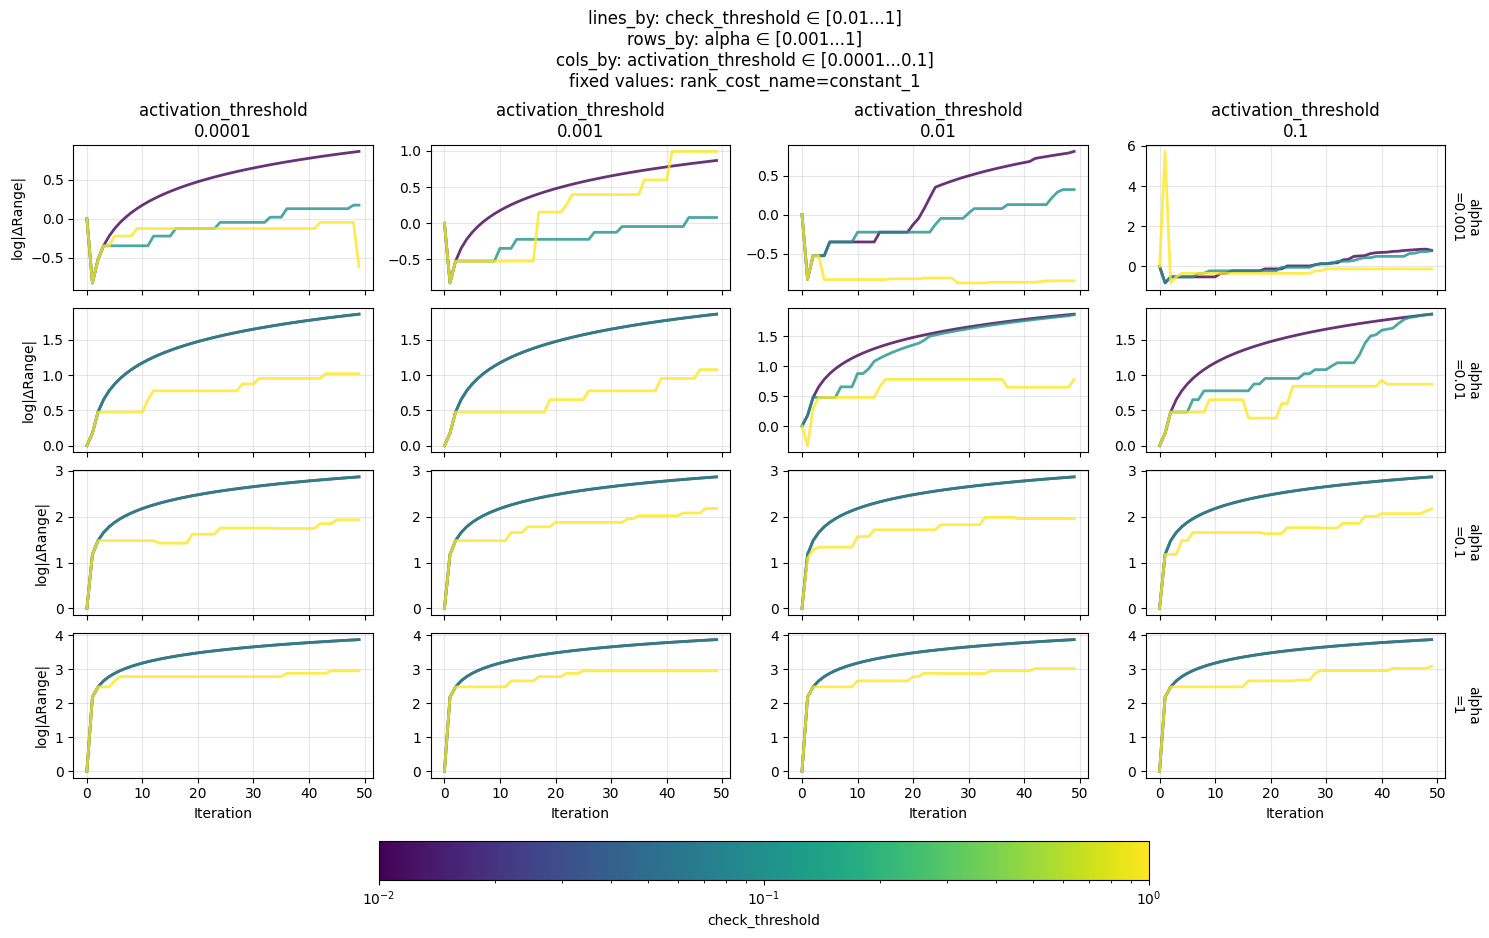

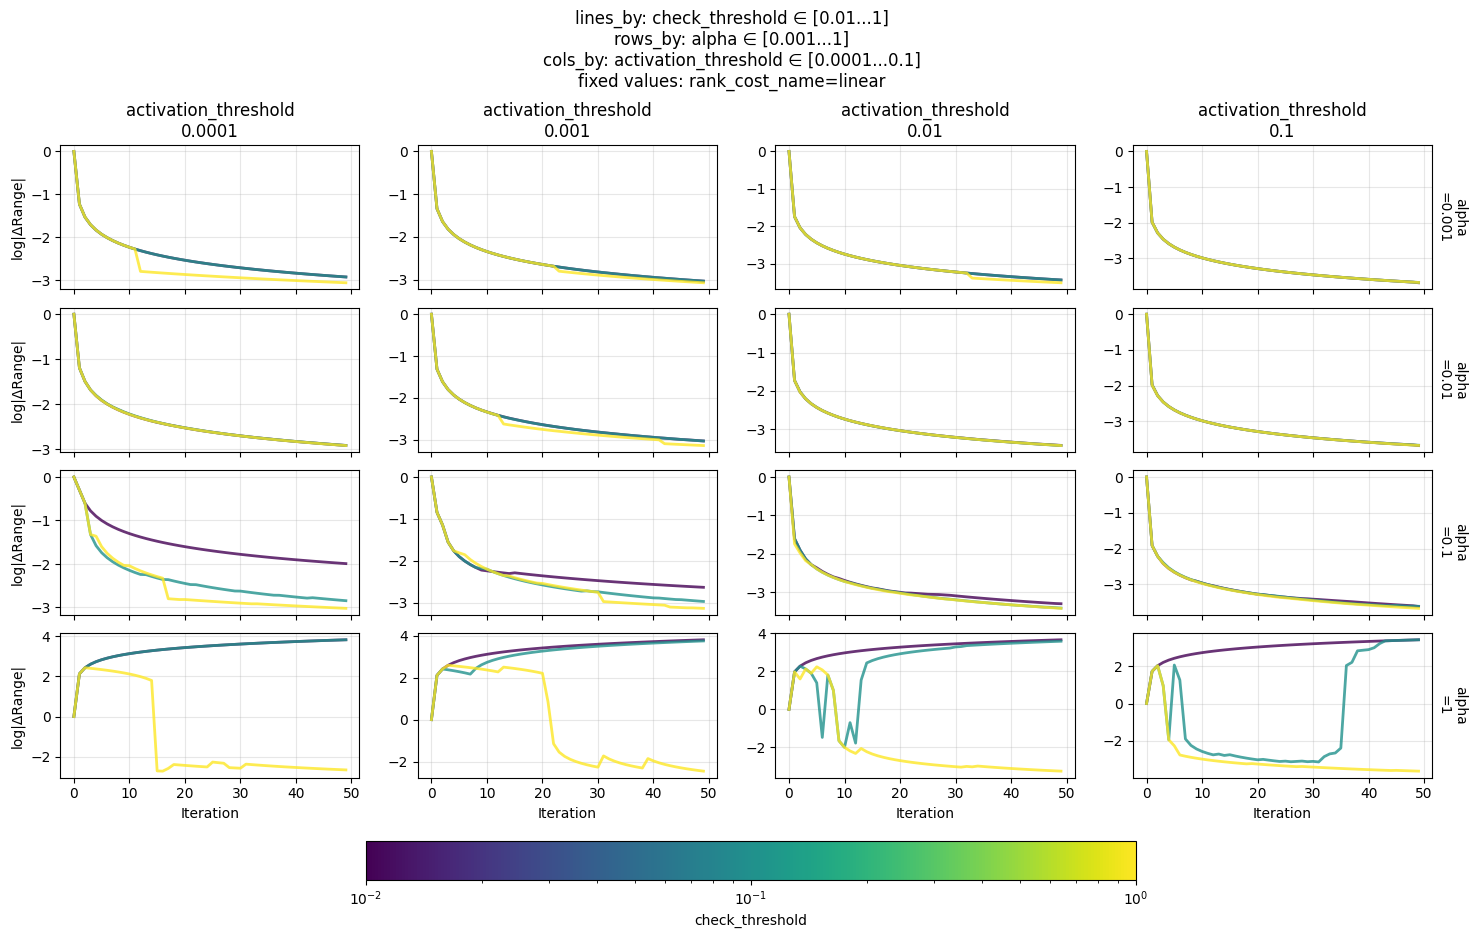

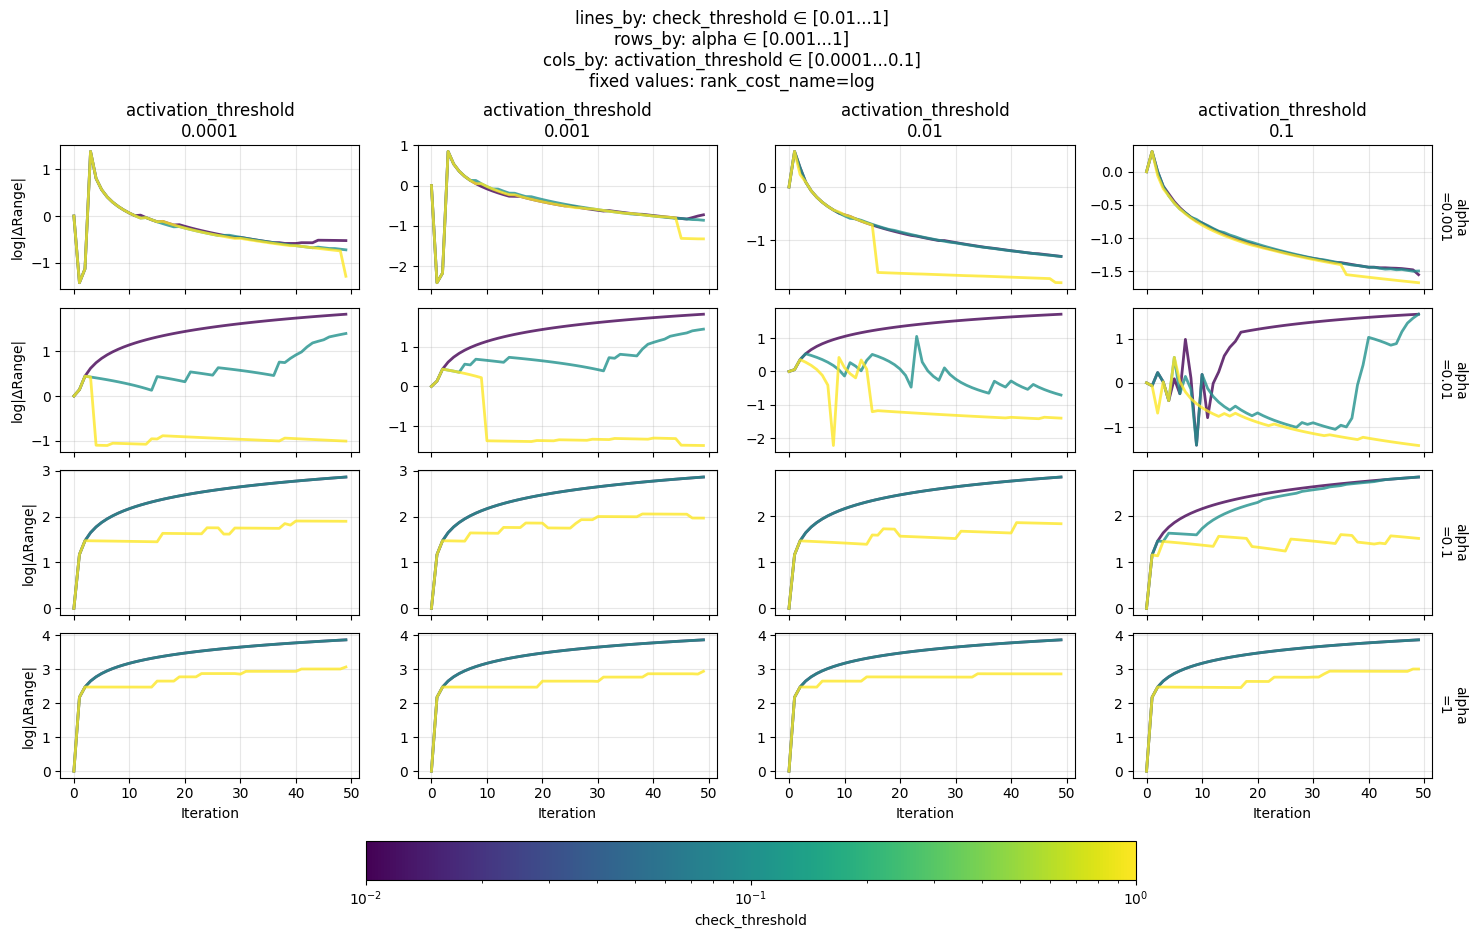

In [9]:
# Evolution histories
from spd.clustering.sweep import plot_evolution_histories

# plot_evolution_histories(
#     sweep_results,
#     metric='non_diag_costs_min',
#     lines_by='alpha',
#     cols_by='activation_threshold',
#     rows_by='check_threshold',
# 	fixed_params={'rank_cost_name': 'constant_0.1'},  # Example fixed parameter
# )

plot_evolution_histories(
    sweep_results,
    # metric='non_diag_costs_min',
	metric='costs_range',
    cols_by='activation_threshold',
    rows_by='alpha',
    lines_by='check_threshold',
	fixed_params={'rank_cost_name': 'constant_1'},
)

plot_evolution_histories(
    sweep_results,
    # metric='non_diag_costs_min',
	metric='costs_range',
    cols_by='activation_threshold',
    rows_by='alpha',
    lines_by='check_threshold',
	fixed_params={'rank_cost_name': 'linear'},
)

plot_evolution_histories(
    sweep_results,
    # metric='non_diag_costs_min',
	metric='costs_range',
    cols_by='activation_threshold',
    rows_by='alpha',
    lines_by='check_threshold',
	fixed_params={'rank_cost_name': 'log'},
)

# plot_evolution_histories(
#     sweep_results,
#     metric='non_diag_costs_min',
#     lines_by='activation_threshold',
#     cols_by='rank_cost_name',
#     rows_by='check_threshold',
# 	fixed_params={'alpha': 0.001},  # Example fixed parameter
# )

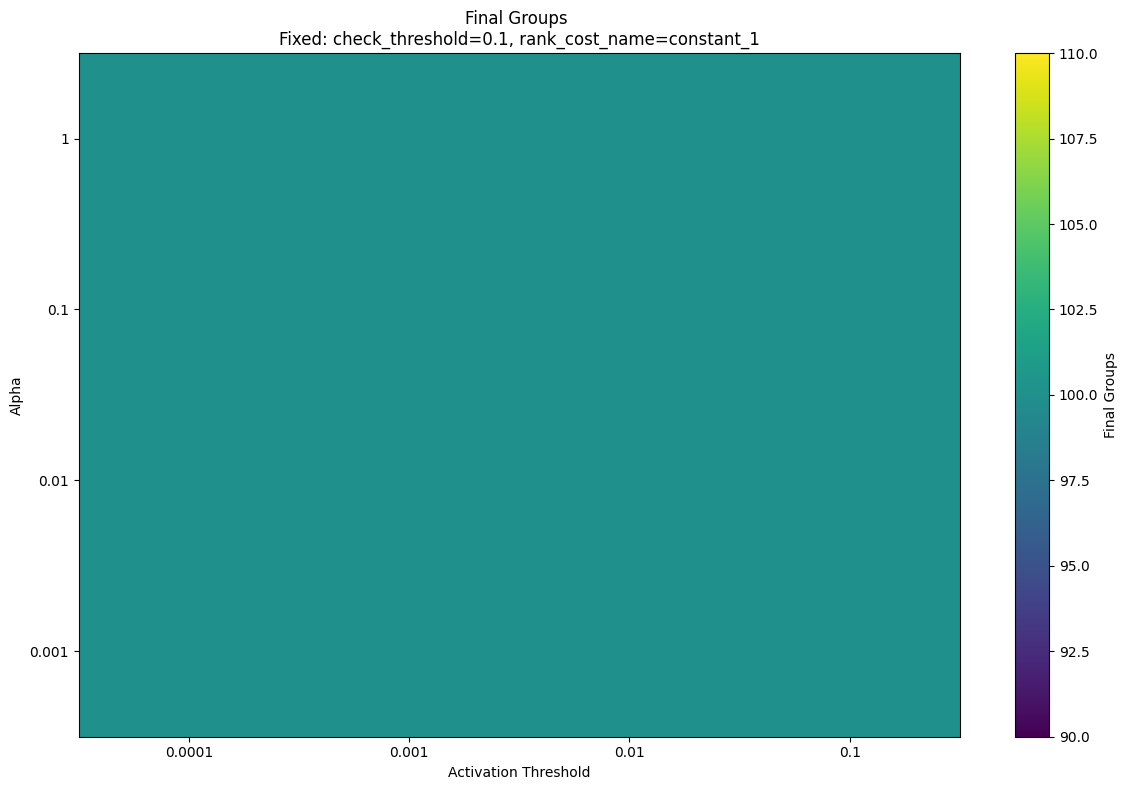

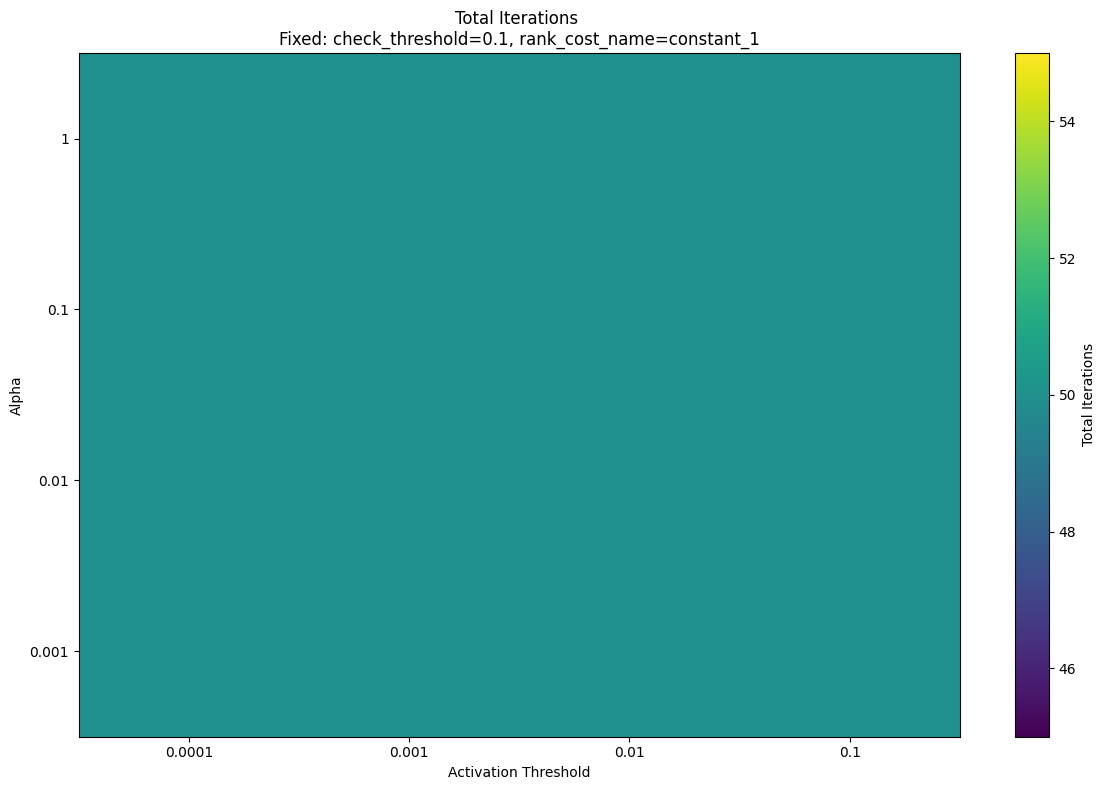

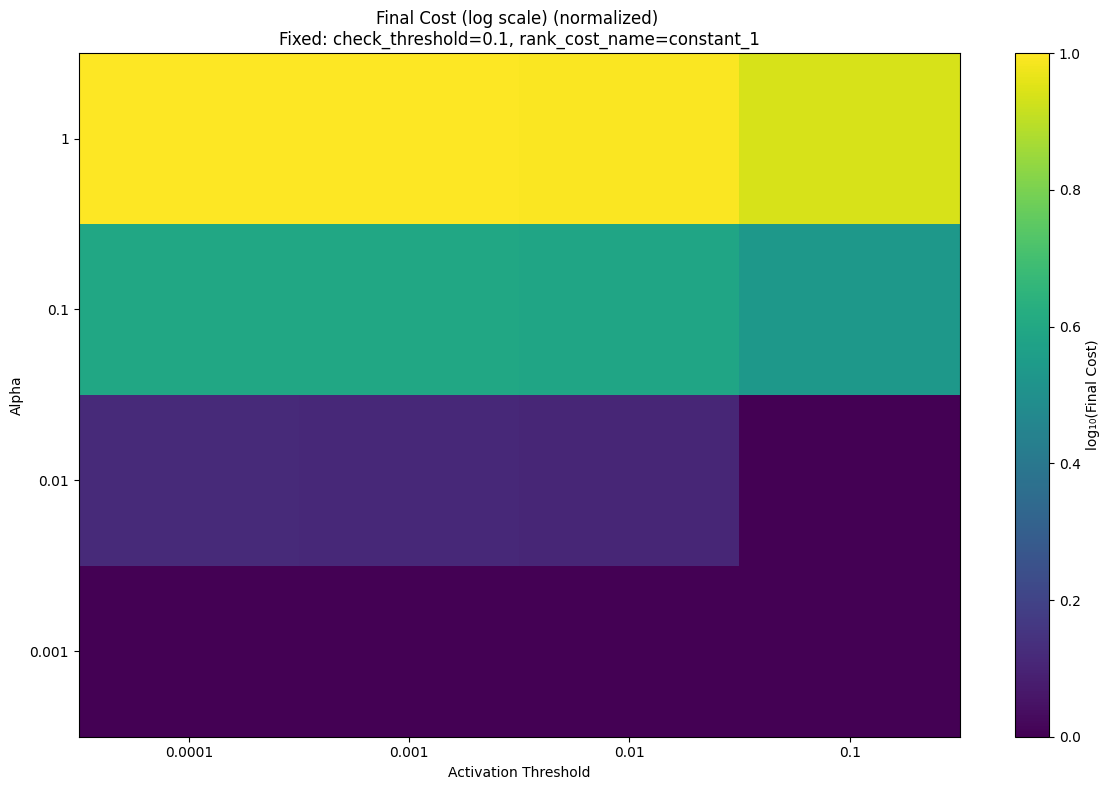

{'heatmap_data': array([[ -106.96000671,  -106.78000641,  -109.07600403,  -122.40200806],
        [  222.13999939,   221.        ,   207.53999329,   112.31999969],
        [ 3572.60009766,  3564.80004883,  3426.80004883,  2474.80004883],
        [37108.        , 36996.        , 35592.        , 26098.        ]]),
 'plot_data': array([[0.        , 0.        , 0.        , 0.        ],
        [0.11757382, 0.11668676, 0.10585296, 0.        ],
        [0.59647522, 0.59609839, 0.58929159, 0.53317882],
        [1.        , 0.99947885, 0.99280862, 0.93931731]]),
 'sample_counts': array([[1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1]]),
 'x_values': [0.0001, 0.001, 0.01, 0.1],
 'y_values': [0.001, 0.01, 0.1, 1.0],
 'x_by': 'activation_threshold',
 'y_by': 'alpha',
 'fixed_params': {'check_threshold': 0.1, 'rank_cost_name': 'constant_1'},
 'statistic_name': 'Final Cost',
 'aggregation': 'mean'}

In [ ]:
# Heatmaps with smart parameter selection

# create_smart_heatmap(
#     sweep_results,
#     statistic_func=lambda r: r.final_k_groups,
#     statistic_name="Final Groups"
# )

# create_smart_heatmap(
#     sweep_results,
#     statistic_func=lambda r: r.total_iterations,
#     statistic_name="Total Iterations"
# )

# create_smart_heatmap(
#     sweep_results,
#     statistic_func=lambda r: r.non_diag_costs_min[-1] if r.non_diag_costs_min else 0,
#     statistic_name="Final Cost",
#     log_scale=True,
#     normalize=True
# )

In [11]:
#%% Stopping Condition Examples

# Example: Stop when cost reaches 2x original
from spd.clustering.sweep import cost_ratio_stopping_condition

stop_at_2x = cost_ratio_stopping_condition(2.0)

# Run with stopping condition
result_with_stop = merge_iteration(
    coact=(coa['coactivations'] > 0.002).float().T @ (coa['coactivations'] > 0.002).float(),
    activation_mask=coa['coactivations'] > 0.002,
    alpha=1.0,
    check_threshold=0.1,
    stopping_condition=stop_at_2x,
    plot_every=None,
    plot_final=False,
)

print(f"{result_with_stop['total_iterations'] = }")
print(f"{result_with_stop['final_k_groups'] = }")

# You can also use the stopping condition in sweeps by modifying sweep_config.iters
# or adding the stopping condition to merge_iteration calls in the sweep

ImportError: cannot import name 'cost_ratio_stopping_condition' from 'spd.clustering.sweep' (/home/miv/projects/MATS/spd/spd/clustering/sweep.py)